---
About this notebook
This is the project for the CASA0006 Data Science for Spatial Systems. 

**Code and data are hosted [here](https://github.com/UCL-SDSV/CASA0006---Data-Science-for-Spatial-Systems---Assessment)**  


---

# Predicting residential sales in Philadelphia

## 1. Introduction


This project aims to analyse the influencing factors of the house values in Philadelphia, Pennsylvania. Housing data from the Office of Property Assessment is used, and a random forest model is utilized to determine the relationship between influencing factors and residential sale prices. An econometric approach, the hedonic model, is used as a theoretical framework for house price prediction. By deconstructing house price into the value of its constituent parts, it captures the "price premium" consumers are willing to pay for an extra bedroom or garage(Lancaster, 1966).

For our purposes, home prices can be deconstructed into three constituent parts 
- Property characteristics, e.g, size of the lot and the number of bedrooms
- Neighborhood features based on amenities or disamenities, e.g., access to transit or exposure to crime
- Spatial component that captures the tendency of housing prices to depend on the prices of neighboring homes

In the development of this project model, the first two components will be focused on and the spatial process will be omitted.



## 1.1 Literature review

The feature in this study was chosen because of its hypothetical relationship with the house price.  

Features such as total living space, garage spaces, fireplaces, number of bathrooms, number of bedrooms, number stories, etc. are directly related to the value of house and are therefore important factors in the price prediction.

The postcode, neighbourhood and census tracts number associated with the spatial location reflect the location attributes of the house, which was proven to be closely related to house prices(Osland, 2010).

Neighbourhood ambience is also a factor in house prices, with people tending to pay higher prices for homes in decent locations, so this study selects several characteristics (e.g. graffiti calls, abandoned cars) reflecting the ambience situation around the house. According to the broken window effect(van der Weele, Flynn and van der Wolk, 2017), this characteristic can also reflect the security situation of the neighbourhood in which the house is located to some extent. 

The safety, amenity and convenience of living also affect the final price of a house. The distance between the house and the aggravated assaults was chosen to reflect the safety of the house, the distance between the house and the university, park and city hall was chosen to reflect the amenity of the house and the distance between the house and the subway stops was chosen to reflect the convenience of the house.

The prognosis of the development of the house's surroundings also affects the selling price of it, and in this study the distance between the house and the new construction permits in surrounding area are used as corresponding features.


## 1.2 Requirements to run the analysis
The enviroment and packages to be used for this analysis is as follows.

In [1]:
import geopandas as gpd
import hvplot.pandas
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings


np.random.seed(105)

%matplotlib inline

/Users/xuanshi/opt/anaconda3/envs/sds2021/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1dev-CAPI-1.14.1) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
warnings.filterwarnings('ignore')

In [3]:
pd.options.display.max_columns = 999

In [4]:
plt.rcParams["figure.figsize"] = (10, 6)

In [5]:
# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Model selection
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

# Pipelines
from sklearn.pipeline import make_pipeline

# Preprocessing
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# 2. Research Qustion



This study focuses on answering the following two questions.
1. what factors have the greatest impact on house prices in Philadelphia?
2. How effective is the model in predicting house prices in Philadelphia?


# 3. Presentation of data

## 3.1 Load house price data from the Office of Property Assessment

The sales data of single-family properties in Philadelphia that had their last sale during 2020 are collected from the Office of Property Assessment. `carto2gpd` package is used to query the data. Data sources can be found at:
 
- [OpenDataPhilly](https://www.opendataphilly.org/dataset/opa-property-assessments)
- [Metadata](http://metadata.phila.gov/#home/datasetdetails/5543865f20583086178c4ee5/representationdetails/55d624fdad35c7e854cb21a4/)

The original dataset has 24912 observations.

In case of SQL query error, all datasets can be downloaded from the datafile.

In [6]:
pip install carto2gpd

Note: you may need to restart the kernel to use updated packages.


In [7]:
import carto2gpd

In [8]:
# the CARTO API url
carto_url = "https://phl.carto.com/api/v2/sql"

# The table name
table_name = "opa_properties_public"

# Only pull 2020 sales for single family residential properties
where = "sale_date >= '2020-01-01' AND sale_date < '2021-01-01'"
where = where + " AND category_code_description = 'Single Family'"

# Run the query
salesRaw = carto2gpd.get(carto_url, table_name, where=where).to_crs(epsg=3857)

# Optional: put it a reproducible order for test/training splits later
salesRaw = salesRaw.sort_values("parcel_number")

In [9]:
salesRaw.head()

geometry  cartodb_id       assessment_date  \
10201  POINT (-8365316.980 4855961.967)       24362  2021-05-25T00:00:00Z   
20585  POINT (-8365348.929 4855822.894)       37640  2021-05-25T00:00:00Z   
10613  POINT (-8365551.531 4855816.216)       16361  2021-05-25T00:00:00Z   
21352  POINT (-8365570.900 4855799.231)       38732                  None   
9515   POINT (-8365434.868 4855682.371)       23542  2021-10-06T00:00:00Z   

      basements            beginning_point book_and_page building_code  \
10201         D          15D94 W HOWARD ST      53726814         O50     
20585         C      40'4 1/2" W HOWARD ST      53629536         O50     
10613         D         111'51/2" W PHILIP      53768090         O50     
21352         C  154 FT W PHILIP                 3621010         O30     
9515          D            203'9" W HOWARD      53708423         O30     

      building_code_description category_code category_code_description  \
10201         ROW 3 STY MASONRY            1              Single Family   
20585         ROW 3 STY MASONRY            1              Single Family   
10613         ROW 3 STY MASONRY            1              Single Family   
21352         ROW 2 STY MASONRY            1              Single Family   
9515          ROW 2 STY MASONRY            1              Single Family   

      census_tract central_air cross_reference date_exterior_condition  depth  \
10201          27            Y            None                    None   49.0   
20585          27            Y            None                    None   40.0   
10613          27            N            None                    None   60.0   
21352          27            N            None                    None   40.0   
9515           27            N            None                    None   35.0   

       exempt_building  exempt_land exterior_condition  fireplaces  frontage  \
10201          45000.0          0.0                  2         0.0      16.0   
20585          45000.0          0.0                  4         0.0      14.0   
10613          45000.0          0.0                  4         0.0      16.0   
21352          45000.0          0.0                  4         0.0      14.0   
9515               0.0          0.0                  4         0.0      12.0   

       fuel  garage_spaces garage_type general_construction geographic_ward  \
10201  None            0.0        None                   A               1    
20585  None            0.0        None                   A               1    
10613  None            0.0        None                   A               1    
21352  None            0.0           0                   A               1    
9515   None            0.0        None                   A               1    

       homestead_exemption house_extension house_number interior_condition  \
10201              45000.0            None        110                    2   
20585              45000.0            None        117                    3   
10613              45000.0            None        226                    4   
21352              45000.0            None        223                    4   
9515                   0.0            None        147                    4   

             location          mailing_address_1 mailing_address_2  \
10201  110 WHARTON ST  SIMPLIFILE LC E-RECORDING              None   
20585     117 REED ST                       None              None   
10613     226 REED ST  SIMPLIFILE LC E-RECORDING              None   
21352  223 GERRITT ST                       None              None   
9515    147 WILDER ST  SIMPLIFILE LC E-RECORDING              None   

      mailing_care_of mailing_city_state  mailing_street mailing_zip  \
10201            None    PHILADELPHIA PA  110 WHARTON ST  19147-5425   
20585            None               None            None        None   
10613            None               None            None        None   
21352            None               None           

In [10]:
len(salesRaw)

24912

In [11]:
#salesRaw.to_csv('/Users/xuanshi/SDSV/CASA0006/06_HW1/houseprice/houseprice_data/salesRaw.csv')

## 3.2 Load census tracts and neighborhoods data

The Philadelphia-based spatial data are collected from the OpenDataPhilly. Spatially join the sales data and neighborhoods/census tracts, such that each sale has an associated neighborhood and census tract.

Note: after performing the first spatial join,  the `drop()` function is nedded to remove the index_right column; otherwise an error will be raised on the second spatial join about duplicate columns.


Census tracts can be downloaded from: http://data.phl.opendata.arcgis.com/datasets/8bc0786524a4486bb3cf0f9862ad0fbf_0.geojson
Neighborhoods can be downloaded from: https://raw.githubusercontent.com/azavea/geo-data/master/Neighborhoods_Philadelphia/Neighborhoods_Philadelphia.geojson

Datasets are also available at the datafile.


In [12]:
url_neighborhooods = "https://raw.githubusercontent.com/azavea/geo-data/master/Neighborhoods_Philadelphia/Neighborhoods_Philadelphia.geojson"
Neighborhoods = gpd.read_file(url_neighborhooods).to_crs(epsg=3857)

In [13]:
url_census = "http://data.phl.opendata.arcgis.com/datasets/8bc0786524a4486bb3cf0f9862ad0fbf_0.geojson"
Census_tracts = gpd.read_file(url_census).to_crs(epsg=3857)

In [14]:
# Neighborhoods.to_csv('/Users/xuanshi/SDSV/CASA0006/06_HW1/houseprice/houseprice_data/Neighborhoods.csv')

In [15]:
# Census_tracts.to_csv('/Users/xuanshi/SDSV/CASA0006/06_HW1/houseprice/houseprice_data/Census_tracts.csv')

In [16]:
#Spatially join
salesRaw = gpd.sjoin(salesRaw,Neighborhoods,op='within',how='left').drop(['index_right'],axis=1)
salesRaw = gpd.sjoin(salesRaw,Census_tracts,op='within',how='left').drop(['index_right'],axis=1)

In [17]:
salesRaw.head()

geometry  cartodb_id_left  \
10201  POINT (-8365316.980 4855961.967)            24362   
20585  POINT (-8365348.929 4855822.894)            37640   
10613  POINT (-8365551.531 4855816.216)            16361   
21352  POINT (-8365570.900 4855799.231)            38732   
9515   POINT (-8365434.868 4855682.371)            23542   

            assessment_date basements            beginning_point  \
10201  2021-05-25T00:00:00Z         D          15D94 W HOWARD ST   
20585  2021-05-25T00:00:00Z         C      40'4 1/2" W HOWARD ST   
10613  2021-05-25T00:00:00Z         D         111'51/2" W PHILIP   
21352                  None         C  154 FT W PHILIP             
9515   2021-10-06T00:00:00Z         D            203'9" W HOWARD   

      book_and_page building_code building_code_description category_code  \
10201      53726814         O50           ROW 3 STY MASONRY            1    
20585      53629536         O50           ROW 3 STY MASONRY            1    
10613      53768090         O50           ROW 3 STY MASONRY            1    
21352       3621010         O30           ROW 2 STY MASONRY            1    
9515       53708423         O30           ROW 2 STY MASONRY            1    

      category_code_description census_tract central_air cross_reference  \
10201             Single Family          27            Y            None   
20585             Single Family          27            Y            None   
10613             Single Family          27            N            None   
21352             Single Family          27            N            None   
9515              Single Family          27            N            None   

      date_exterior_condition  depth  exempt_building  exempt_land  \
10201                    None   49.0          45000.0          0.0   
20585                    None   40.0          45000.0          0.0   
10613                    None   60.0          45000.0          0.0   
21352                    None   40.0          45000.0          0.0   
9515                     None   35.0              0.0          0.0   

      exterior_condition  fireplaces  frontage  fuel  garage_spaces  \
10201                  2         0.0      16.0  None            0.0   
20585                  4         0.0      14.0  None            0.0   
10613                  4         0.0      16.0  None            0.0   
21352                  4         0.0      14.0  None            0.0   
9515                   4         0.0      12.0  None            0.0   

      garage_type general_construction geographic_ward  homestead_exemption  \
10201        None                   A               1               45000.0   
20585        None                   A               1               45000.0   
10613        None                   A               1               45000.0   
21352           0                   A               1               45000.0   
9515         None                   A               1                   0.0   

      house_extension house_number interior_condition        location  \
10201            None        110                    2  110 WHARTON ST   
20585            None        117                    3     117 REED ST   
10613            None        226                    4     226 REED ST   
21352            None        223                    4  223 GERRITT ST   
9515             None        147                    4   147 WILDER ST   

               mailing_address_1 mailing_address_2 mailing_care_of  \
10201  SIMPLIFILE LC E-RECORDING              None            None   
20585                       None              None            None   
10613  SIMPLIFILE LC E-RECORDING              None            None   
21352                       None              None            None   
9515   SIMPLIFILE LC E-RECORDING              None            None   

      mailing_city_state  mailing_street mailing_zip  market_value  \
10201    PHILADELPHIA PA  110 WHARTON ST  19147-5425      341600.0   
20585             

In [18]:
# change cols names

salesRaw.rename(columns={'listname':'neighborhoods'}, inplace=True)
salesRaw.rename(columns={'NAME10':'census_tracts'}, inplace=True)

## 3.3 Data preparation

The raw data was very messy and there was a lot of missing data, the `missingno` package is used to visualize the missing data and select the features(internal characteristics) that this study is looking for.

The sales data over 1 million dollar and under 3,000 dollar are removed from the original dataset to avoid the effect of outliers on the regression, leaving 18,706 observations.

In [19]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [20]:
import missingno as msno

In [21]:
# Visualize the first half of columns
# and then the second half
ncol = len(salesRaw.columns)

fields1 = salesRaw.columns[:ncol//2]
fields2 = salesRaw.columns[ncol//2:]

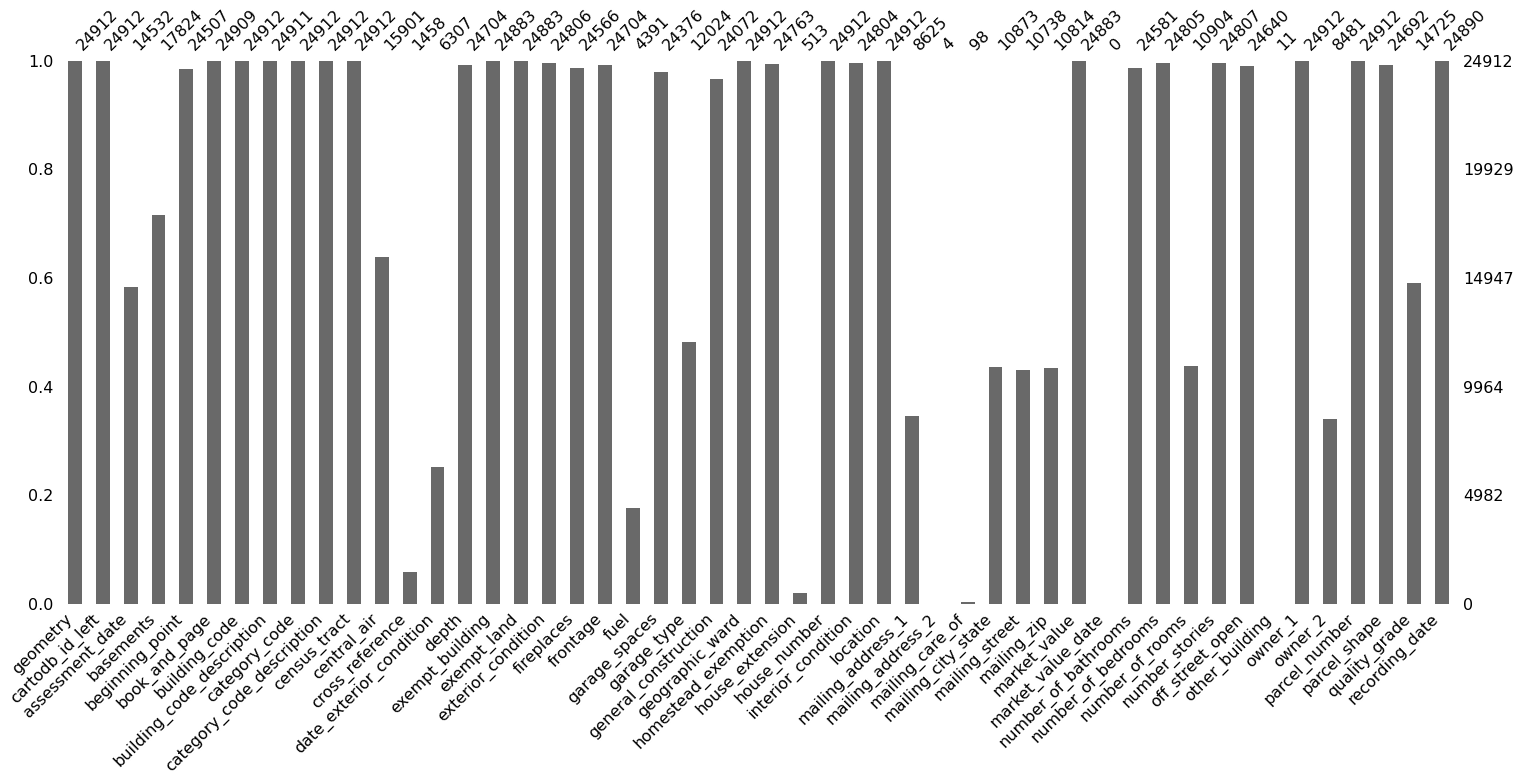

In [22]:
# The first half of columns
msno.bar(salesRaw[fields1]);


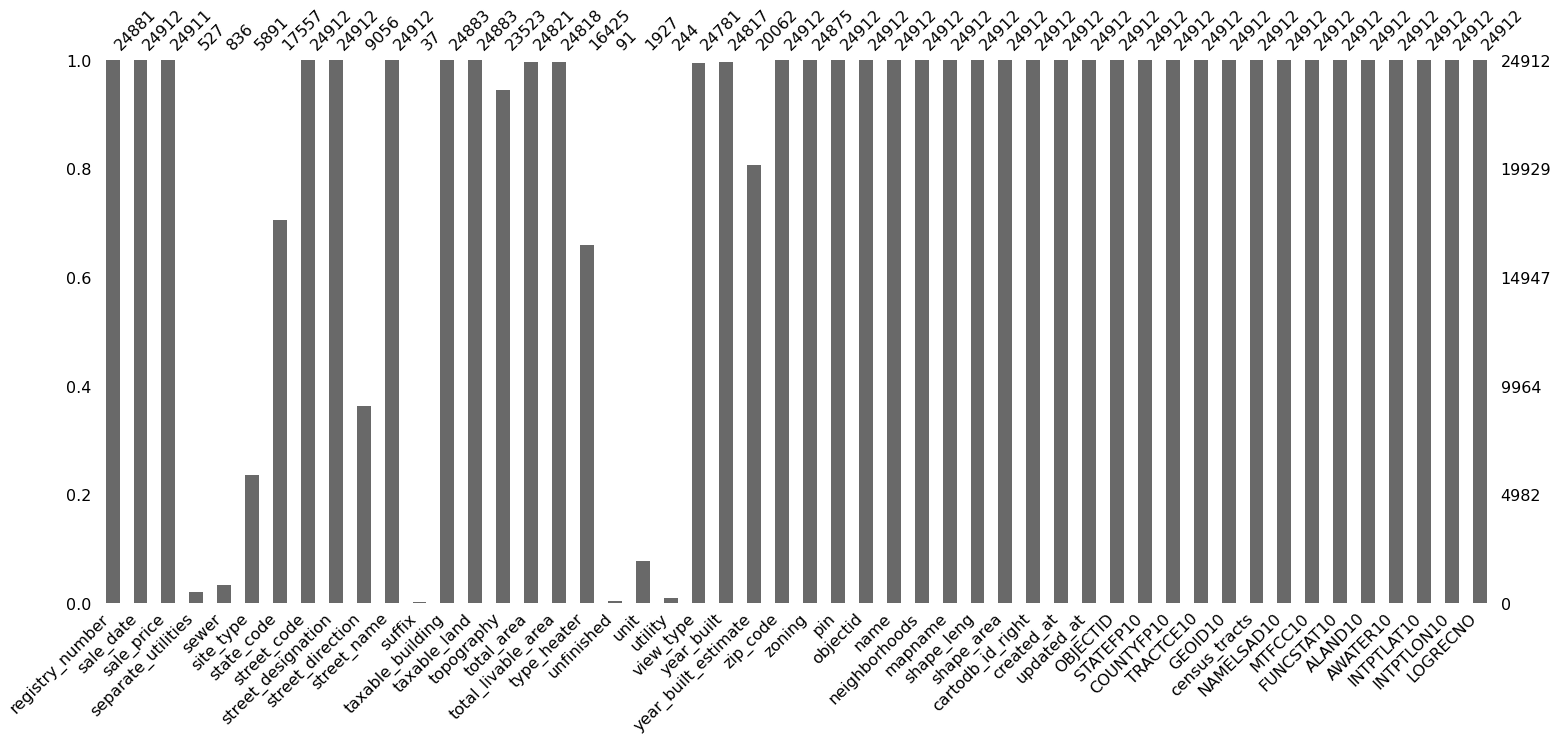

In [23]:
# The second half of columns
msno.bar(salesRaw[fields2]);

In [24]:
# The feature columns(Internal characteristics) we want to use
cols = [
    "sale_price",
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
    "exterior_condition",
    "zip_code",
    "geometry",
    "neighborhoods",
    "census_tracts"
]

# Trim to these columns and remove NaNs
sales = salesRaw[cols].dropna()

# Trim zip code to only the first five digits
sales["zip_code"] = sales["zip_code"].astype(str).str.slice(0, 5)

# set neighborhoods and census tracts as string
sales['neighborhoods'] = sales['neighborhoods'].astype(str)
sales['census_tracts'] = sales['census_tracts'].astype(str)

In [25]:
# Trim very low and very high sales
valid = (sales["sale_price"] > 3000) & (sales["sale_price"] < 1e6)
sales = sales.loc[valid]

In [26]:
len(sales)

18706


# 4. Spatial amenity/disamenity features engineering

Exclued the spatial information captured from ZIP code, neighborhoods, and census tracts, the study also add some distance-based amenity/disamenity features. Through the data for a certain type of amenity, e.g., parks, subway stops, or disamenity, e.g., crimes, the study use scikit learn's nearest neighbor algorithm to calculate the distance from each sale to its nearest neighbor in the amenity/disamenity datasets.

In this study, generated spatial amenity/disamenity features inclued:

Distance from each sale to:

- Graffiti 311 Calls
- Subway Stops
- Universities
- Parks
- City Hall
- New Construction Permits
- Aggravated Assaults
- Abandoned Vehicle 311 Calls

## 4.1  Distance to the *nearest* graffiti 311 Calls

16,264 graffiti calls observations generated in 2020 were collected from the OpenDataPhilly data site. Converting the CRS to EPSG=3857 to get distances in meters (rather than degrees), this study extract out the x/y coordinates of the geometry column of each dataset (sales and grafitti calls). The $k$ nearest neighbors algorithm from scikit learn is used to calculate the nearest neighbor distances. For each sale, we find the $k$ nearest neighbors in the second dataset (graffiti calls, crimes, etc),and then calculate the average distance from the sale to those $k$ neighbors.

- `grafDists`: For each sale, the distances to the 5 nearest graffiti calls

- `grafIndices`: For each sale, the index of each of the 5 neighbors in the original dataset

A hex map of the Graffiti 311 Calls feature are shown as below.


Data Source can be found at: https://www.opendataphilly.org/dataset/311-service-and-information-requests


In [27]:
# the 311 table
table_name = "public_cases_fc"

# Peak at the first row of data
carto2gpd.get(carto_url, table_name, limit=1)

geometry  cartodb_id  objectid  service_request_id  \
0  POINT (-75.15551 39.91786)           1  13555346            14700770   

   status status_notes         service_name service_code  agency_responsible  \
0  Closed         None  Street Light Outage      SR-ST04  Streets Department   

  service_notice    requested_datetime      updated_datetime  \
0           None  2022-01-28T06:50:18Z  2022-03-19T02:49:44Z   

  expected_datetime           address zipcode  \
0              None  2436 S ORKNEY ST    None   

                                           media_url        lat        lon  
0  https://d17aqltn7cihbm.cloudfront.net/uploads/...  39.917856 -75.155515

In [28]:
# Select only those for grafitti and in 2020
where_2020 = "requested_datetime >= '01-01-2020' and requested_datetime < '01-01-2021'"
where_grafitti = "service_name = 'Graffiti Removal'"
where = f"{where_2020} and {where_grafitti}"

# Pull the subset we want
graffiti = carto2gpd.get(carto_url, table_name, where=where)

In [29]:
# Remove rows with missing geometries
graffiti = graffiti.loc[graffiti.geometry.notnull()]

In [30]:
len(graffiti)

16264

In [31]:
graffiti.head()

geometry  cartodb_id  objectid  service_request_id  \
0  POINT (-75.04179 40.01761)        2775  12165663            13610312   
2  POINT (-75.02920 40.04072)        3374  12165752            13679533   
3  POINT (-75.13710 39.97224)        3375  12165753            13679578   
4  POINT (-75.12162 39.98767)        3382  12165667            13610733   
5  POINT (-75.13438 39.96522)        3387  12165745            13652865   

   status    status_notes      service_name service_code  \
0  Closed           Other  Graffiti Removal      SR-CL01   
2  Closed  Issue Resolved  Graffiti Removal      SR-CL01   
3  Closed  Issue Resolved  Graffiti Removal      SR-CL01   
4  Closed  Issue Resolved  Graffiti Removal      SR-CL01   
5  Closed  Issue Resolved  Graffiti Removal      SR-CL01   

                   agency_responsible   service_notice    requested_datetime  \
0  Community Life Improvement Program  7 Business Days  2020-08-12T16:37:34Z   
2  Community Life Improvement Program  7 Business Days  2020-09-19T09:39:25Z   
3  Community Life Improvement Program  7 Business Days  2020-09-19T12:03:13Z   
4  Community Life Improvement Program  7 Business Days  2020-08-12T17:06:50Z   
5  Community Life Improvement Program  7 Business Days  2020-09-04T08:50:47Z   

       updated_datetime     expected_datetime             address zipcode  \
0  2022-03-12T06:10:18Z  2020-08-23T20:00:00Z      5200 UNRUH AVE    None   
2  2022-03-12T06:10:18Z  2020-09-29T20:00:00Z  7915 FRANKFORD AVE    None   
3  2022-03-12T06:10:18Z  2020-09-29T20:00:00Z     1401 MASCHER ST    None   
4  2022-03-12T06:10:18Z  2020-08-23T20:00:00Z  2724 FRANKFORD AVE    None   
5  2022-03-12T06:10:18Z  2020-09-14T20:00:00Z   945 FRANKFORD AVE    None   

                                           media_url        lat        lon  
0  https://d17aqltn7cihbm.cloudfront.net/uploads/...  40.017615 -75.041792  
2  https://d17aqltn7cihbm.cloudfront.net/uploads/...  40.040718 -75.029198  
3                                               None  39.972236 -75.137099  
4  https://d17aqltn7cihbm.cloudfront.net/uploads/...  39.987666 -75.121624  
5  https://d17aqltn7cihbm.cloudfront.net/uploads/...  39.965222 -75.134381

In [32]:
# graffiti.to_csv('/Users/xuanshi/SDSV/CASA0006/06_HW1/houseprice/houseprice_data/graffiti.csv')

In [33]:
# Do the CRS conversion
sales_3857 = sales.to_crs(epsg=3857)
graffiti_3857 = graffiti.to_crs(epsg=3857)

In [34]:
def get_xy_from_geometry(df):
    """
    Return a numpy array with two columns, where the
    first holds the `x` geometry coordinate and the second
    column holds the `y` geometry coordinate
    """
    x = df.geometry.x
    y = df.geometry.y

    return np.column_stack((x, y))  # stack as columns

In [35]:
# Extract x/y for sales
salesXY = get_xy_from_geometry(sales_3857)

# Extract x/y for grafitti calls
graffitiXY = get_xy_from_geometry(graffiti_3857)

In [36]:
salesXY.shape

(18706, 2)

In [37]:
graffitiXY.shape

(16264, 2)

In [38]:
from sklearn.neighbors import NearestNeighbors

In [39]:
# STEP 1: Initialize the algorithm
k = 5
nbrs = NearestNeighbors(n_neighbors=k)

# STEP 2: Fit the algorithm on the "neighbors" dataset
nbrs.fit(graffitiXY)

# STEP 3: Get distances for sale to neighbors
grafDists, grafIndices = nbrs.kneighbors(salesXY)

In [40]:
print("length of sales = ", len(salesXY))
print("shape of grafDists = ", grafDists.shape)
print("shape of grafIndices = ", grafIndices.shape)

length of sales =  18706
shape of grafDists =  (18706, 5)
shape of grafIndices =  (18706, 5)


In [41]:
# The distances from the first sale to the 5 nearest neighbors
grafDists[0]

array([32.58421305, 50.97272832, 56.08568591, 76.70297958, 87.74522976])

In [42]:
# The coordinates for the first sale
x0, y0 = salesXY[0]
x0, y0

(-8365348.929096215, 4855822.893625472)

In [43]:
# The indices for the 5 nearest graffiti calls
grafIndices[0]

array([11383,  7536,  2671, 14659,  2117])

In [44]:
# the graffiti neighbors
sale0_neighbors = graffitiXY[grafIndices[0]]
sale0_neighbors

array([[-8365328.89158787,  4855797.19869991],
       [-8365314.19741509,  4855860.20219498],
       [-8365332.78777005,  4855876.60639633],
       [-8365305.18053633,  4855759.89036695],
       [-8365267.66586793,  4855789.79508962]])

In [45]:
# Access the first and second column for x/y values
neighbors_x = sale0_neighbors[:, 0]
neighbors_y = sale0_neighbors[:, 1]

# The x/y differences between neighbors and first sale coordinates
dx = neighbors_x - x0
dy = neighbors_y - y0

# The Euclidean dist
manual_dists = (dx ** 2 + dy ** 2) ** 0.5

In [46]:
manual_dists

array([32.58421305, 50.97272832, 56.08568591, 76.70297958, 87.74522976])

In [47]:
grafDists[0]

array([32.58421305, 50.97272832, 56.08568591, 76.70297958, 87.74522976])

In [48]:
# Average distance to neighbors
avgGrafDist = grafDists.mean(axis=1)

# Set zero distances to be small, but nonzero
# IMPORTANT: THIS WILL AVOID INF DISTANCES WHEN DOING THE LOG
avgGrafDist[avgGrafDist == 0] = 1e-5

# Calculate log of distances
sales["logDistGraffiti"] = np.log10(avgGrafDist)

In [49]:
sales.head()

sale_price  total_livable_area  total_area  garage_spaces  fireplaces  \
20585    256500.0              1131.0      513.00            0.0         0.0   
10613    395000.0              1248.0      930.00            0.0         0.0   
21352    225000.0               896.0      560.00            0.0         0.0   
22186    160000.0              1260.0      956.25            0.0         0.0   
20697    256500.0               882.0      587.20            0.0         0.0   

       number_of_bathrooms  number_of_bedrooms  number_stories  \
20585                  1.0                 4.0             3.0   
10613                  1.0                 3.0             3.0   
21352                  1.0                 3.0             2.0   
22186                  1.0                 3.0             3.0   
20697                  1.0                 3.0             3.0   

      exterior_condition zip_code                          geometry  \
20585                  4    19147  POINT (-8365348.929 4855822.894)   
10613                  4    19147  POINT (-8365551.531 4855816.216)   
21352                  4    19147  POINT (-8365570.900 4855799.231)   
22186                  4    19147  POINT (-8365505.110 4855715.614)   
20697                  4    19147  POINT (-8365507.225 4855682.226)   

      neighborhoods census_tracts  logDistGraffiti  
20585     Pennsport         27.02         1.784033  
10613     Pennsport         27.02         2.353144  
21352     Pennsport         27.02         2.350248  
22186     Pennsport         27.02         2.266357  
20697     Pennsport         27.02         2.261540

In [50]:
# Load the City Limits to plot too
import esri2gpd

# From OpenDataPhilly's page
url = "https://services.arcgis.com/fLeGjb7u4uXqeF9q/arcgis/rest/services/City_Limits/FeatureServer/0"
city_limits = esri2gpd.get(url).to_crs(epsg=3857)

In [51]:
#city_limits.to_csv('/Users/xuanshi/SDSV/CASA0006/06_HW1/houseprice/houseprice_data/city_limits.csv')

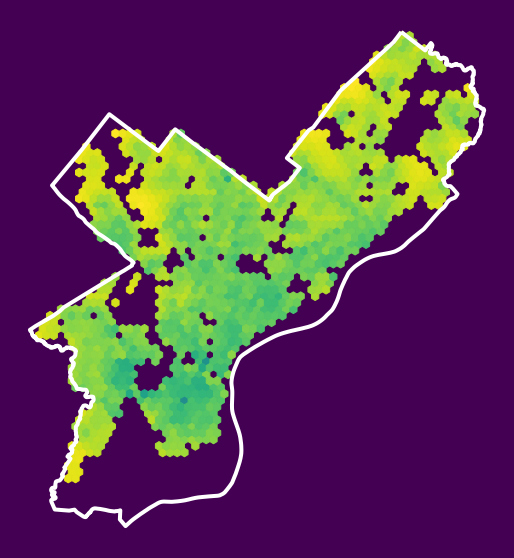

In [52]:
fig, ax = plt.subplots(figsize=(10, 10), facecolor=plt.get_cmap("viridis")(0))

# Plot the log of the Graffiti distance
x = salesXY[:, 0]
y = salesXY[:, 1]
ax.hexbin(x, y, C=sales["logDistGraffiti"].values, gridsize=60)

# Plot the city limits
city_limits.plot(ax=ax, facecolor="none", edgecolor="white", linewidth=4)

ax.set_axis_off()
ax.set_aspect("equal")

## 4.2 Distance to the subway stops

The `osmnx` package and the `ox.geometries_from_polygon()` function are used to get subway stops in Philadelphia. `station=subway` function is used to get the stops on the Market-Frankford and Broad St. subway lines. 

Set $k=1$ to get the distance to the nearest subway stop.

A hex map of the subway stops feature are shown as below.

Source: [OSM Wikipedia](https://wiki.openstreetmap.org/wiki/Tag:station%3Dsubway)


In [53]:
import osmnx as ox

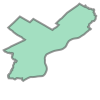

In [54]:
# Get the geometry from the city limits
city_limits_outline = city_limits.to_crs(epsg=4326).squeeze().geometry

city_limits_outline

In [55]:
# Get the subway stops within the city limits
subway = ox.geometries_from_polygon(city_limits_outline, tags={"station": "subway"})

# Convert to 3857 (meters)
subway = subway.to_crs(epsg=3857)

subway.head()

addr:city                name network operator  \
element_type osmid                                                          
node         469917297  Philadelphia  15th-16th & Locust   PATCO    PATCO   
             469917298  Philadelphia   9th-10th & Locust   PATCO    PATCO   
             471026103  Philadelphia  12th-13th & Locust   PATCO    PATCO   
             650938316           NaN         63rd Street   SEPTA    SEPTA   
             650959043           NaN         56th Street   SEPTA    SEPTA   

                       platforms public_transport  railway station subway  \
element_type osmid                                                          
node         469917297         1          station  station  subway    yes   
             469917298         1          station  station  subway    yes   
             471026103         1          station  station  subway    yes   
             650938316       NaN          station  station  subway    yes   
             650959043       NaN          station  station  subway    yes   

                       wheelchair  wikidata  \
element_type osmid                            
node         469917297        yes  Q4551078   
             469917298        yes  Q4646737   
             471026103         no  Q4548965   
             650938316        NaN       NaN   
             650959043        NaN  Q4640769   

                                                  wikipedia  \
element_type osmid                                            
node         469917297  en:15–16th & Locust (PATCO station)   
             469917298   en:9–10th & Locust (PATCO station)   
             471026103  en:12–13th & Locust (PATCO station)   
             650938316                                  NaN   
             650959043                                  NaN   

                                                geometry addr:postcode  \
element_type osmid                                                       
node         469917297  POINT (-8367552.610 4858465.747)           NaN   
             469917298  POINT (-8366424.042 4858281.683)           NaN   
             471026103  POINT (-8366949.703 4858366.817)         19107   
             650938316  POINT (-8376424.717 4860524.238)           NaN   
             650959043  POINT (-8374883.844 4860274.795)           NaN   

                       operator_1 addr:housenumber addr:street  \
element_type osmid                                               
node         469917297        NaN              NaN         NaN   
             469917298        NaN              NaN         NaN   
             471026103        NaN              NaN         NaN   
             650938316        NaN              NaN         NaN   
             650959043        NaN              NaN         NaN   

                       railway:position internet_access old_name addr:state  \
element_type osmid                                                            
node         469917297              NaN             NaN      NaN        NaN   
             469917298              NaN             NaN      NaN        NaN   
             471026103              NaN             NaN      NaN        NaN   
             650938316              NaN             NaN      NaN        NaN   
             650959043              NaN             NaN      NaN        NaN   

                       short_name elevator tram  
element_type osmid                               
node         469917297        NaN      NaN  NaN  
             469917298        NaN      NaN  NaN  
             471026103        NaN      NaN  NaN  
             650938316        NaN      NaN  NaN  
             650959043        NaN      NaN  NaN

In [56]:
#subway.to_csv('/Users/xuanshi/SDSV/CASA0006/06_HW1/houseprice/houseprice_data/subway.csv')


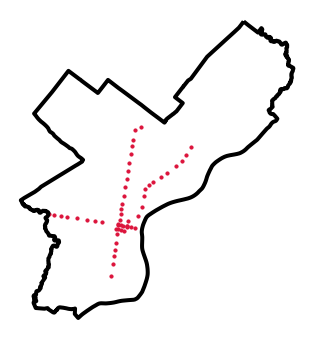

In [57]:
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the subway locations
subway.plot(ax=ax, markersize=10, color="crimson")

# City limits, too
city_limits.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=4)

ax.set_axis_off()

In [58]:
# STEP 1: x/y coordinates of subway stops (in EPGS=3857)
subwayXY = get_xy_from_geometry(subway.to_crs(epsg=3857))

# STEP 2: Initialize the algorithm
nbrs = NearestNeighbors(n_neighbors=1)

# STEP 3: Fit the algorithm on the "neighbors" dataset
nbrs.fit(subwayXY)

# STEP 4: Get distances for sale to neighbors
subwayDists, subwayIndices = nbrs.kneighbors(salesXY)

# STEP 5: add back to the original dataset
sales["logDistSubway"] = np.log10(subwayDists[:, 0])

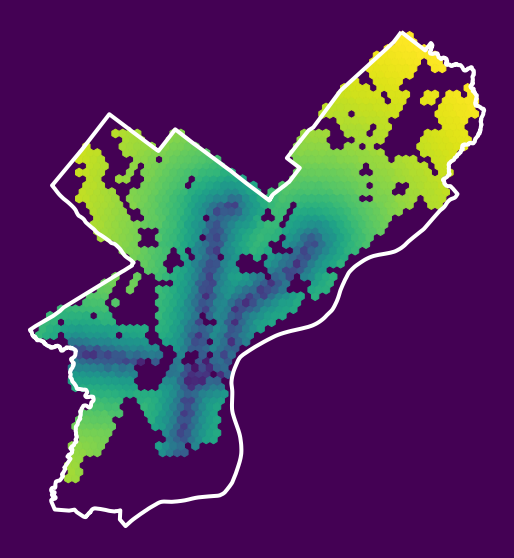

In [59]:
fig, ax = plt.subplots(figsize=(10, 10), facecolor=plt.get_cmap("viridis")(0))

# Plot the log of the subway distance
x = salesXY[:, 0]
y = salesXY[:, 1]
ax.hexbin(x, y, C=sales["logDistSubway"].values, gridsize=60)

# Plot the city limits
city_limits.plot(ax=ax, facecolor="none", edgecolor="white", linewidth=4)

ax.set_axis_off()
ax.set_aspect("equal")

## 4.3 Distance to the *nearest* university/college

According to the same method, the study calculate several other spatial features with modified the `get_xy_from_geometry()` function.

New feature: Distance to the *nearest* university/college

- Source: [OpenDataPhilly](https://www.opendataphilly.org/dataset/philadelphia-universities-and-colleges)
- GeoService URL: https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/Universities_Colleges/FeatureServer/0


In [60]:
def get_xy_from_geometry(df):
    """
    Return a numpy array with two columns, where the 
    first holds the `x` geometry coordinate and the second 
    column holds the `y` geometry coordinate
    """
    # NEW: use the centroid.x and centroid.y to support Polygon() and Point() geometries 
    x = df.geometry.centroid.x
    y = df.geometry.centroid.y
    
    return np.column_stack((x, y)) # stack as columns

In [61]:
# Get the data
url = "https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/Universities_Colleges/FeatureServer/0"
univs = esri2gpd.get(url)

#univs.to_csv('/Users/xuanshi/SDSV/CASA0006/06_HW1/houseprice/houseprice_data/univs.csv')

# Get the X/Y
univXY = get_xy_from_geometry(univs.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=1)
nbrs.fit(univXY)
univDists, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales['logDistUniv'] = np.log10(univDists.mean(axis=1))

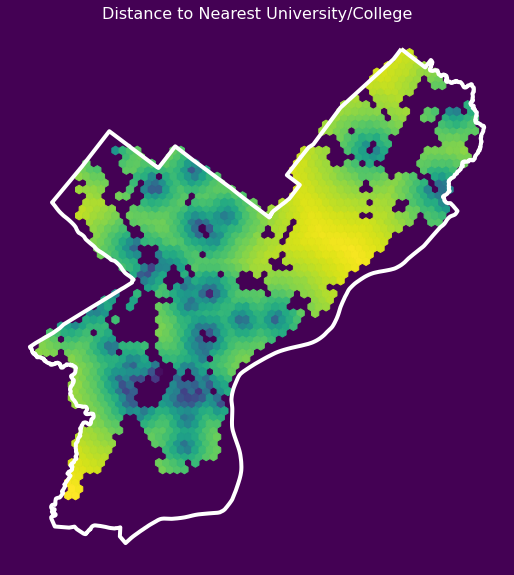

In [62]:
fig, ax = plt.subplots(figsize=(10,10), facecolor=plt.get_cmap('viridis')(0))

x = salesXY[:,0]
y = salesXY[:,1]
ax.hexbin(x, y, C=np.log10(univDists.mean(axis=1)), gridsize=60)

# Plot the city limits
city_limits.plot(ax=ax, facecolor='none', edgecolor='white', linewidth=4)

ax.set_axis_off()
ax.set_aspect("equal")
ax.set_title("Distance to Nearest University/College", fontsize=16, color='white');

## 4.4 Distance to the *nearest* Parks

New feature: Distance to the *nearest* park centroid

* Source: [OpenDataPhilly](https://www.opendataphilly.org/dataset/parks-recreation-program-sites)
* GeoService URL:  https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/PPR_Program_Sites/FeatureServer/0/


In [63]:
# Get the data
url = " https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/PPR_Program_Sites/FeatureServer/0/"
parks = esri2gpd.get(url)

#parks.to_csv('/Users/xuanshi/SDSV/CASA0006/06_HW1/houseprice/houseprice_data/parks.csv')

# Get the X/Y
parksXY = get_xy_from_geometry(parks.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=1)
nbrs.fit(parksXY)
parksDists, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales["logDistParks"] = np.log10(parksDists.mean(axis=1))

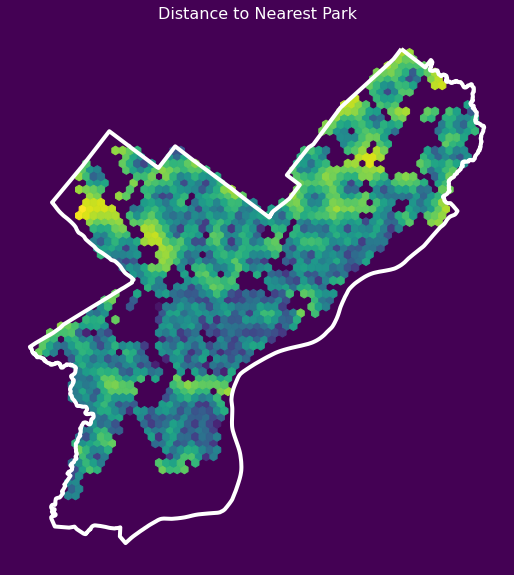

In [64]:
fig, ax = plt.subplots(figsize=(10, 10), facecolor=plt.get_cmap("viridis")(0))

x = salesXY[:, 0]
y = salesXY[:, 1]
ax.hexbin(x, y, C=np.log10(parksDists.mean(axis=1)), gridsize=60)

# Plot the city limits
city_limits.plot(ax=ax, facecolor="none", edgecolor="white", linewidth=4)

ax.set_axis_off()
ax.set_aspect("equal")
ax.set_title("Distance to Nearest Park", fontsize=16, color="white");

## 4.5 Distance to the *nearest* City Hall

New feature: Distance to City Hall.

* Source: [OpenDataPhilly](https://www.opendataphilly.org/dataset/city-landmarks)
* GeoService URL: https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/CITY_LANDMARKS/FeatureServer/0


In [65]:
# Get the data
url = "https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/CITY_LANDMARKS/FeatureServer/0"
cityHall = esri2gpd.get(
    url, where="NAME = 'City Hall' AND FEAT_TYPE = 'Municipal Building'"
)

#cityHall.to_csv('/Users/xuanshi/SDSV/CASA0006/06_HW1/houseprice/houseprice_data/cityHall.csv')

# Get the X/Y
cityHallXY = get_xy_from_geometry(cityHall.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=1)
nbrs.fit(cityHallXY)
cityHallDist, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales["logDistCityHall"] = np.log10(cityHallDist.mean(axis=1))

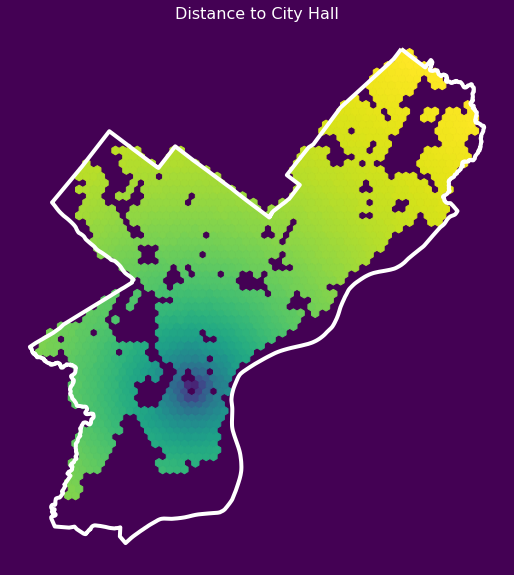

In [66]:
fig, ax = plt.subplots(figsize=(10, 10), facecolor=plt.get_cmap("viridis")(0))

x = salesXY[:, 0]
y = salesXY[:, 1]
ax.hexbin(x, y, C=np.log10(cityHallDist.mean(axis=1)), gridsize=60)

# Plot the city limits
city_limits.plot(ax=ax, facecolor="none", edgecolor="white", linewidth=4)

ax.set_axis_off()
ax.set_aspect("equal")
ax.set_title("Distance to City Hall", fontsize=16, color="white");

## 4.6 Distance to the *nearest* New Construction Permits

New feature: Distance to the 5 nearest new construction permits from 2019

* Source: [OpenDataPhilly](https://www.opendataphilly.org/dataset/licenses-and-inspections-building-permits)
* CARTO table name: "permits"


In [67]:
# Table name
table_name = "permits"

# Where clause
where = "permitissuedate >= '2019-01-01' AND permitissuedate < '2020-01-01'"
where = where + " AND permitdescription='NEW CONSTRUCTION PERMIT'"

# Query
permits = carto2gpd.get(carto_url, table_name, where=where)

# Remove missing
permits = permits.loc[permits.geometry.notnull()]

#permits.to_csv('/Users/xuanshi/SDSV/CASA0006/06_HW1/houseprice/houseprice_data/permits.csv')

# Get the X/Y
permitsXY = get_xy_from_geometry(permits.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=5)
nbrs.fit(permitsXY)
permitsDist, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales["logDistPermits"] = np.log10(permitsDist.mean(axis=1))

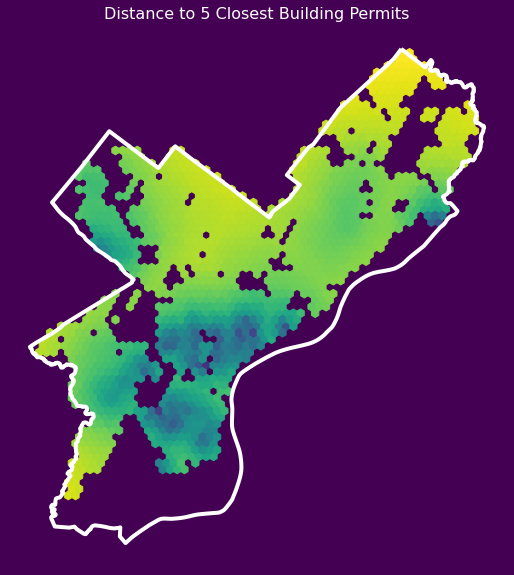

In [68]:
fig, ax = plt.subplots(figsize=(10, 10), facecolor=plt.get_cmap("viridis")(0))

x = salesXY[:, 0]
y = salesXY[:, 1]
ax.hexbin(x, y, C=np.log10(permitsDist.mean(axis=1)), gridsize=60)

# Plot the city limits
city_limits.plot(ax=ax, facecolor="none", edgecolor="white", linewidth=4)

ax.set_axis_off()
ax.set_aspect("equal")
ax.set_title("Distance to 5 Closest Building Permits", fontsize=16, color="white");

## 4.7 Distance to the *nearest* Aggravated Assaults

New feature: Distance to the 5 nearest aggravated assaults in 2019

* Source: [OpenDataPhilly](https://www.opendataphilly.org/dataset/crime-incidents)
* CARTO table name: "incidents_part1_part2"


In [69]:
# Table name
table_name = "incidents_part1_part2"

# Where selection
where = "dispatch_date >= '2019-01-01' AND dispatch_date < '2020-01-01'"
where = where + " AND Text_General_Code IN ('Aggravated Assault No Firearm', 'Aggravated Assault Firearm')"

# Query
assaults = carto2gpd.get(carto_url, table_name, where=where)

# Remove missing 
assaults = assaults.loc[assaults.geometry.notnull()]

#assaults.to_csv('/Users/xuanshi/SDSV/CASA0006/06_HW1/houseprice/houseprice_data/assaults.csv')
    
# Get the X/Y
assaultsXY = get_xy_from_geometry(assaults.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=5)
nbrs.fit(assaultsXY)
assaultDists, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales['logDistAssaults'] = np.log10(assaultDists.mean(axis=1))

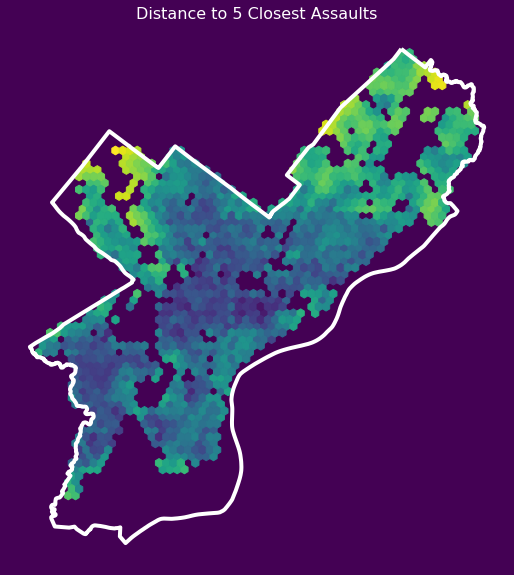

In [70]:
fig, ax = plt.subplots(figsize=(10, 10), facecolor=plt.get_cmap("viridis")(0))

x = salesXY[:, 0]
y = salesXY[:, 1]
ax.hexbin(x, y, C=np.log10(assaultDists.mean(axis=1)), gridsize=60)

# Plot the city limits
city_limits.plot(ax=ax, facecolor="none", edgecolor="white", linewidth=4)

ax.set_axis_off()
ax.set_aspect("equal")
ax.set_title("Distance to 5 Closest Assaults", fontsize=16, color="white");

## 4.8 Distance to the *nearest* Abandonded Vehicle 311 Calls

New feature: Distance to the 5 nearest abandoned vehicle 311 calls in 2020

* Source: [OpenDataPhilly](https://www.opendataphilly.org/dataset/311-service-and-information-requests)
* CARTO table name: "public_cases_fc"


In [71]:
# Table name
table_name = "public_cases_fc"

# Where selection
where = "requested_datetime >= '2020-01-01' AND requested_datetime < '2021-01-01'"
where = where + " AND service_name = 'Abandoned Vehicle'"

# Query
cars = carto2gpd.get(carto_url, table_name, where=where)

# Remove missing
cars = cars.loc[cars.geometry.notnull()]

#cars.to_csv('/Users/xuanshi/SDSV/CASA0006/06_HW1/houseprice/houseprice_data/cars.csv')

# Get the X/Y
carsXY = get_xy_from_geometry(cars.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=5)
nbrs.fit(carsXY)
carDists, _ = nbrs.kneighbors(salesXY)

# Handle any sales that have 0 distances
carDists[carDists == 0] = 1e-5  # a small, arbitrary value

# Add the new feature
sales["logDistCars"] = np.log10(carDists.mean(axis=1))

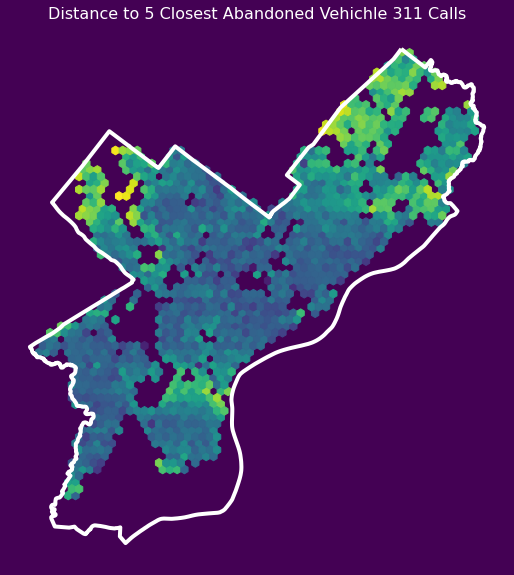

In [72]:
fig, ax = plt.subplots(figsize=(10, 10), facecolor=plt.get_cmap("viridis")(0))

x = salesXY[:, 0]
y = salesXY[:, 1]
ax.hexbin(x, y, C=np.log10(carDists.mean(axis=1)), gridsize=60)

# Plot the city limits
city_limits.plot(ax=ax, facecolor="none", edgecolor="white", linewidth=4)

ax.set_axis_off()
ax.set_aspect("equal")
ax.set_title(
    "Distance to 5 Closest Abandoned Vehichle 311 Calls", fontsize=16, color="white"
);

# 5 Regression Assumption Checks
The study use `seaborn` to generate the correlation matrix of this model. The correlation matrix here shows that there is no significant multicollinearity and we can include all features in the regression.


In [73]:
# Extract out only the features we want to use
feature_cols = [
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
    "logDistGraffiti", # NEW
    "logDistSubway", # NEW
    "logDistUniv", # NEW
    "logDistParks", # NEW
    "logDistCityHall", # NEW 
    "logDistPermits", # NEW
    "logDistAssaults", # NEW
    "logDistCars",
    "exterior_condition", 
    "zip_code",
    "neighborhoods",
    "census_tracts",
]

plt.figure(figsize=(16, 6))

sns.heatmap(
    sales[feature_cols].corr(), cmap="coolwarm", annot=True, vmin=-1, vmax=1
)

<AxesSubplot:>

# 6 Prediction Model Construction

## 6.1 Handle the categorical data

A substitute of `pd.get_dummies()`, **one-hot encoding** technique in scikit learn is used to handle the categorical data in this study. After creating a new column for each category, [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) function and [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)  function are used to represent each category as a vector of 1s and 0s.

The `pipeline` object is applied to build a two-step pipeline that includes both numerical columns and categorical columnsPrediction Model Construction for the column transformer and the regressor.

In [74]:
# Numerical columns
num_cols = [
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
    "logDistGraffiti", # NEW
    "logDistSubway", # NEW
    "logDistUniv", # NEW
    "logDistParks", # NEW
    "logDistCityHall", # NEW 
    "logDistPermits", # NEW
    "logDistAssaults", # NEW
    "logDistCars" # NEW
]

# Categorical columns
cat_cols = ["exterior_condition", "zip_code", "neighborhoods", "census_tracts"]

In [75]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [76]:
# Set up the column transformer with two transformers
transformer = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)


#Note: the `handle_unknown='ignore'` parameter ensures that if categories show up in the training set, but not the test set, no error will be raised.

In [77]:
# Two steps in pipeline: preprocessor and then regressor
pipe = make_pipeline(
    transformer, RandomForestRegressor(n_estimators=20, random_state=105)
)

## 6.2 Split the training/test dataset 70/30%

The training data and testing data are splitted fairly under using `train_test_split` function.

In [78]:
# Split the data 70/30
train_set, test_set = train_test_split(sales, test_size=0.3, random_state=105)

# the target labels
y_train = np.log(train_set["sale_price"])
y_test = np.log(test_set["sale_price"])

## 6.3 Optimize hyperparameters 

Use `GridSearchCV` to perform a k-fold cross validation to optimize the hyperparameters of the `RandomForestRegressor`.

**Note**: In hyperparametric optimisation, an increase in the value of `n_estimators` can significantly improve the model performance of a random forest. The optimal R^2 scores for the parameters obtained in the tests were around 0.7. However, due to runtime constraints, only a limited number of parameters are chosen here for demonstration purposes.

In [79]:
model_name = "randomforestregressor"
param_grid = {
    f"{model_name}__n_estimators": [ 1,5,10],
    f"{model_name}__max_depth": [None, 10],
}

param_grid


{'randomforestregressor__n_estimators': [1, 5, 10],
 'randomforestregressor__max_depth': [None, 10]}

## 6.4 Run the random forest model

In [80]:
# Create the grid and use 5-fold CV
grid = GridSearchCV(pipe, param_grid, cv=5)

# Run the search
grid.fit(train_set, y_train);

# 7 Results

## 7.1 Evaluate the best estimator on the test set

In hyperparametric optimisation, an increase in the value of `n_estimators` can significantly improve the model accuracy of a random forest. The optimal R^2 scores for the parameters obtained in the tests were around 0.7. When running the random forest model with the restricted parameters, an R^2 score of 0.65 was returned.

In [81]:
grid.best_params_

{'randomforestregressor__max_depth': 10,
 'randomforestregressor__n_estimators': 10}

In [82]:
# Evaluate the best random forest model
best_random = grid.best_estimator_
grid.score(test_set, y_test)

0.6543727485902806

## 7.2 Evaluate a linear model (baseline) on the test set

In this study, we tested the test dataset with linear regression. an R^2 score of 0.68 indicates that the difference in performance between the linear model and the random forest model for this study is not significant in cases where the hyperparameters of the random forest regression model are not optimal.

With optimal hyperparameters for the random forest regression model, the random forest model has slightly higher R^2 for Philadelphia house prices than the linear model.

In [83]:
from sklearn.linear_model import LinearRegression

In [84]:
# Make a linear model pipeline
linear_pipeline = make_pipeline(transformer, LinearRegression())

# Fit on the training data
linear_pipeline.fit(train_set, y_train)

# What's the test score?
linear_pipeline.score(test_set, y_test)

0.6828497199359629

## 7.3 Feature importances

In order to measure the importance of each factor in predicting the sale price of houses in Philadelphia, we create the full list of columns (numerical and categorical factors), the feature importance plot is shown below.

As can be seen from the plot, the safety (represented by logDistAssaults, logDistGraffiti), amenity (represented by logDistCityHall, logDistSubway, logDistParks, logDistUniv), quality and comfort (represented by total livable area, total area, number of bathrooms), and future development expectations (represented by logDistPermits) of the house have the most significant impact on the house price. ZIP codes for 19140 (North Philadelphia) also important.


In [85]:
# The best model
regressor = grid.best_estimator_["randomforestregressor"]

# The one-hot step
ohe = transformer.named_transformers_["cat"]

# One column for each category type!
ohe_cols = ohe.get_feature_names()

# Full list of columns is numerical + one-hot
features = num_cols + list(ohe_cols)


In [86]:
# Create the dataframe with importances
importance = pd.DataFrame(
    {"Feature": features, "Importance": regressor.feature_importances_}
)

# Sort importance in descending order and get the top
importance = importance.sort_values("Importance", ascending=False).iloc[:30]

# Plot
importance.hvplot.barh(
    x="Feature", y="Importance", flip_yaxis=True, height=500
)


:Bars   [Feature]   (Importance)

## 7.4 Calculate the percent error of the model predictions for each sale in the test set
With the model we generated above, the study make predictions on the test set.
The percent error in terms of sale price is calculated to measure the accuracy of the model. 

The average absolute percentage error reaches 50% when using the random forest model.

In [87]:
test_set.index

Int64Index([22637, 16110, 23798, 14648,  4544, 13143, 12284, 23951, 22014,
             6451,
            ...
            13749,  6256, 12113,  8858, 15354, 23506, 14767, 21923, 12193,
            16437],
           dtype='int64', length=5612)

In [88]:
# Extract the test data from the original dataset
# This will include the geometry data
X = sales.loc[test_set.index]

In [89]:
# test data extracted from our original data frame
X.head()

sale_price  total_livable_area  total_area  garage_spaces  fireplaces  \
22637    255000.0              1023.0     1020.27            0.0         0.0   
16110    317000.0               886.0      784.37            1.0         0.0   
23798    185000.0              1536.0     1485.00            1.0         0.0   
14648    221000.0              1260.0     1814.28            1.0         0.0   
4544     100000.0              1772.0     2813.00            0.0         0.0   

       number_of_bathrooms  number_of_bedrooms  number_stories  \
22637                  1.0                 3.0             3.0   
16110                  1.0                 3.0             2.0   
23798                  1.0                 4.0             2.0   
14648                  1.0                 3.0             2.0   
4544                   1.0                 4.0             2.0   

      exterior_condition zip_code                          geometry  \
22637                  3    19127  POINT (-8373936.226 4869876.071)   
16110                  4    19125  POINT (-8362424.677 4863483.380)   
23798                  4    19135  POINT (-8353560.640 4870550.634)   
14648                  4    19114  POINT (-8347476.362 4876083.342)   
4544                   4    19139  POINT (-8376499.691 4861132.136)   

                     neighborhoods census_tracts  logDistGraffiti  \
22637                     Manayunk           214         1.951802   
16110  Fishtown - Lower Kensington           160         2.227278   
23798                       Tacony           326         2.456999   
14648                 Morrell Park        353.01         2.675154   
4544                     Overbrook           100         2.824212   

       logDistSubway  logDistUniv  logDistParks  logDistCityHall  \
22637       3.927257     3.304491      2.787655         4.106589   
16110       3.040694     3.062470      2.476401         3.813523   
23798       3.628259     3.842635      2.072971         4.251209   
14648       4.086400     2.974670      2.798493         4.415849   
4544        2.787109     3.484796      2.691379         3.980504   

       logDistPermits  logDistAssaults  logDistCars  
22637        2.770209         2.500544     2.146782  
16110        1.977046         2.458471     1.906807  
23798        3.513599         2.210523     1.857254  
14648        3.569945         2.694292     2.210343  
4544         3.490437         2.167635     1.730279

In [90]:
test_set.head()

sale_price  total_livable_area  total_area  garage_spaces  fireplaces  \
22637    255000.0              1023.0     1020.27            0.0         0.0   
16110    317000.0               886.0      784.37            1.0         0.0   
23798    185000.0              1536.0     1485.00            1.0         0.0   
14648    221000.0              1260.0     1814.28            1.0         0.0   
4544     100000.0              1772.0     2813.00            0.0         0.0   

       number_of_bathrooms  number_of_bedrooms  number_stories  \
22637                  1.0                 3.0             3.0   
16110                  1.0                 3.0             2.0   
23798                  1.0                 4.0             2.0   
14648                  1.0                 3.0             2.0   
4544                   1.0                 4.0             2.0   

      exterior_condition zip_code                          geometry  \
22637                  3    19127  POINT (-8373936.226 4869876.071)   
16110                  4    19125  POINT (-8362424.677 4863483.380)   
23798                  4    19135  POINT (-8353560.640 4870550.634)   
14648                  4    19114  POINT (-8347476.362 4876083.342)   
4544                   4    19139  POINT (-8376499.691 4861132.136)   

                     neighborhoods census_tracts  logDistGraffiti  \
22637                     Manayunk           214         1.951802   
16110  Fishtown - Lower Kensington           160         2.227278   
23798                       Tacony           326         2.456999   
14648                 Morrell Park        353.01         2.675154   
4544                     Overbrook           100         2.824212   

       logDistSubway  logDistUniv  logDistParks  logDistCityHall  \
22637       3.927257     3.304491      2.787655         4.106589   
16110       3.040694     3.062470      2.476401         3.813523   
23798       3.628259     3.842635      2.072971         4.251209   
14648       4.086400     2.974670      2.798493         4.415849   
4544        2.787109     3.484796      2.691379         3.980504   

       logDistPermits  logDistAssaults  logDistCars  
22637        2.770209         2.500544     2.146782  
16110        1.977046         2.458471     1.906807  
23798        3.513599         2.210523     1.857254  
14648        3.569945         2.694292     2.210343  
4544         3.490437         2.167635     1.730279

In [91]:
# Predictions for log of total trip counts
log_predictions = grid.best_estimator_.predict(test_set)

# Convert the predicted test values from log
X['prediction'] = np.exp(log_predictions)

In [92]:
X

sale_price  total_livable_area  total_area  garage_spaces  fireplaces  \
22637    255000.0              1023.0     1020.27            0.0         0.0   
16110    317000.0               886.0      784.37            1.0         0.0   
23798    185000.0              1536.0     1485.00            1.0         0.0   
14648    221000.0              1260.0     1814.28            1.0         0.0   
4544     100000.0              1772.0     2813.00            0.0         0.0   
...           ...                 ...         ...            ...         ...   
23506    450000.0              1530.0     1170.13            0.0         0.0   
14767     66000.0               882.0     1605.60            0.0         0.0   
21923    220000.0               960.0     1053.36            0.0         0.0   
12193    156000.0              1200.0     1050.00            1.0         0.0   
16437    465000.0              1696.0      780.00            0.0         0.0   

       number_of_bathrooms  number_of_bedrooms  number_stories  \
22637                  1.0                 3.0             3.0   
16110                  1.0                 3.0             2.0   
23798                  1.0                 4.0             2.0   
14648                  1.0                 3.0             2.0   
4544                   1.0                 4.0             2.0   
...                    ...                 ...             ...   
23506                  2.0                 3.0             2.0   
14767                  1.0                 3.0             2.0   
21923                  1.0                 2.0             2.0   
12193                  2.0                 3.0             2.0   
16437                  0.0                 3.0             3.0   

      exterior_condition zip_code                          geometry  \
22637                  3    19127  POINT (-8373936.226 4869876.071)   
16110                  4    19125  POINT (-8362424.677 4863483.380)   
23798                  4    19135  POINT (-8353560.640 4870550.634)   
14648                  4    19114  POINT (-8347476.362 4876083.342)   
4544                   4    19139  POINT (-8376499.691 4861132.136)   
...                  ...      ...                               ...   
23506                  2    19125  POINT (-8363369.001 4861443.550)   
14767                  4    19144  POINT (-8366824.914 4871115.325)   
21923                  4    19148  POINT (-8367002.024 4853594.215)   
12193                  4    19120  POINT (-8362410.985 4872465.537)   
16437                  1    19125  POINT (-8363662.550 4862992.196)   

                     neighborhoods census_tracts  logDistGraffiti  \
22637                     Manayunk           214         1.951802   
16110  Fishtown - Lower Kensington           160         2.227278   
23798                       Tacony           326         2.456999   
14648                 Morrell Park        353.01         2.675154   
4544                     Overbrook           100         2.824212   
...                            ...           ...              ...   
23506  Fishtown - Lower Kensington           143         1.614435   
14767                       Wister           245         2.389523   
21923             Stadium District           372         2.546724   
12193         Melrose Park Gardens           272         2.399037   
16437              East Kensington           161         2.130465   

       logDistSubway  logDistUniv  logDistParks  logDistCityHall  \
22637       3.927257     3.304491      2.787655         4.106589   
16110       3.040694     3.062470      2.476401         3.813523   
23798       3.628259     3.842635      2.072971         4.251209   
14648       4.086400     2.974670      2.798493         4.415849   
4544        2.787109     3.484796      2.691379         3.980504   
...              ...          ...           ...              ...   
23506       2.879946     3.430711      2.650358         3.653627   
14767       3.242294     2.

In [93]:
y_test

22637    12.449019
16110    12.666657
23798    12.128111
14648    12.305918
4544     11.512925
           ...    
23506    13.017003
14767    11.097410
21923    12.301383
12193    11.957611
16437    13.049793
Name: sale_price, Length: 5612, dtype: float64

In [94]:
X['percent_error'] = np.abs(X['sale_price'] - X['prediction'])/X['sale_price']

In [95]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

In [96]:
print('mean abs percent error : {}%'.format(round(mape(X['sale_price'], X['prediction'])),2))

mean abs percent error : 50%


## 7.5 Plot a map of the median percent error by census tract

Merge the census tract geometries back in, group the data frame of test sales by the census tracts column and take the median of you percent error column, a data frame that has the property geometries, census tract data, and percent errors for all of the sales in the test set is created.

With the help of `geopandas`, a map of the median percent error by census tracts is shown below. The brighter the colour in the map, the greater the median percent error.

The downtown area has a larger median percent error than overall, with census tract 56 on the south side near Philadelphia International Airport, census tracts 229, 230, 234 on the northwest side adjacent to Wissahickon Vally Park, and census tracts 297, 322, 324, 327 along the Delaware River also shares a larger median percent error.

In [108]:
X.head()

sale_price  total_livable_area  total_area  garage_spaces  fireplaces  \
22637    255000.0              1023.0     1020.27            0.0         0.0   
16110    317000.0               886.0      784.37            1.0         0.0   
23798    185000.0              1536.0     1485.00            1.0         0.0   
14648    221000.0              1260.0     1814.28            1.0         0.0   
4544     100000.0              1772.0     2813.00            0.0         0.0   

       number_of_bathrooms  number_of_bedrooms  number_stories  \
22637                  1.0                 3.0             3.0   
16110                  1.0                 3.0             2.0   
23798                  1.0                 4.0             2.0   
14648                  1.0                 3.0             2.0   
4544                   1.0                 4.0             2.0   

      exterior_condition zip_code                          geometry  \
22637                  3    19127  POINT (-8373936.226 4869876.071)   
16110                  4    19125  POINT (-8362424.677 4863483.380)   
23798                  4    19135  POINT (-8353560.640 4870550.634)   
14648                  4    19114  POINT (-8347476.362 4876083.342)   
4544                   4    19139  POINT (-8376499.691 4861132.136)   

                     neighborhoods census_tracts  logDistGraffiti  \
22637                     Manayunk           214         1.951802   
16110  Fishtown - Lower Kensington           160         2.227278   
23798                       Tacony           326         2.456999   
14648                 Morrell Park        353.01         2.675154   
4544                     Overbrook           100         2.824212   

       logDistSubway  logDistUniv  logDistParks  logDistCityHall  \
22637       3.927257     3.304491      2.787655         4.106589   
16110       3.040694     3.062470      2.476401         3.813523   
23798       3.628259     3.842635      2.072971         4.251209   
14648       4.086400     2.974670      2.798493         4.415849   
4544        2.787109     3.484796      2.691379         3.980504   

       logDistPermits  logDistAssaults  logDistCars     prediction  \
22637        2.770209         2.500544     2.146782  236769.780998   
16110        1.977046         2.458471     1.906807  219747.258048   
23798        3.513599         2.210523     1.857254  131780.115438   
14648        3.569945         2.694292     2.210343  238599.907744   
4544         3.490437         2.167635     1.730279   96255.464345   

       percent_error  
22637       0.071491  
16110       0.306791  
23798       0.287675  
14648       0.079638  
4544        0.037445

In [98]:
df = X[['sale_price','percent_error','census_tracts']]
df

sale_price  percent_error census_tracts
22637    255000.0       0.071491           214
16110    317000.0       0.306791           160
23798    185000.0       0.287675           326
14648    221000.0       0.079638        353.01
4544     100000.0       0.037445           100
...           ...            ...           ...
23506    450000.0       0.173211           143
14767     66000.0       0.019774           245
21923    220000.0       0.618705           372
12193    156000.0       0.160109           272
16437    465000.0       0.087115           161

[5612 rows x 3 columns]

In [99]:
geoid = df.groupby(['census_tracts'])['percent_error'].median().reset_index()

In [100]:
geoid

census_tracts  percent_error
0               1       0.172060
1           10.01       0.155881
2           10.02       0.231869
3             100       0.438541
4             101       0.251058
..            ...            ...
361            95       0.517713
362            96       0.451437
363         98.01       0.250835
364         98.02       0.295084
365          9800       0.291821

[366 rows x 2 columns]

In [101]:
Census_tracts

OBJECTID STATEFP10 COUNTYFP10 TRACTCE10      GEOID10 NAME10  \
0           1        42        101    009400  42101009400     94   
1           2        42        101    009500  42101009500     95   
2           3        42        101    009600  42101009600     96   
3           4        42        101    013800  42101013800    138   
4           5        42        101    013900  42101013900    139   
..        ...       ...        ...       ...          ...    ...   
379       380        42        101    037200  42101037200    372   
380       381        42        101    038300  42101038300    383   
381       382        42        101    039000  42101039000    390   
382       383        42        101    037800  42101037800    378   
383       384        42        101    037700  42101037700    377   

           NAMELSAD10 MTFCC10 FUNCSTAT10  ALAND10  AWATER10   INTPTLAT10  \
0     Census Tract 94   G5020          S   366717         0  +39.9632709   
1     Census Tract 95   G5020          S   319070         0  +39.9658709   
2     Census Tract 96   G5020          S   405273         0  +39.9655396   
3    Census Tract 138   G5020          S   341256         0  +39.9764504   
4    Census Tract 139   G5020          S   562934         0  +39.9750563   
..                ...     ...        ...      ...       ...          ...   
379  Census Tract 372   G5020          S  1028984         0  +39.9129487   
380  Census Tract 383   G5020          S  3064496         0  +40.0108630   
381  Census Tract 390   G5020          S  2032689         0  +40.0357300   
382  Census Tract 378   G5020          S  3760084   1936838  +39.9805802   
383  Census Tract 377   G5020          S   736894         0  +39.9824381   

       INTPTLON10 LOGRECNO                                           geometry  
0    -075.2322437    10429  POLYGON ((-8374483.498 4860210.393, -8374414.8...  
1    -075.2379140    10430  POLYGON ((-8375161.875 4861368.604, -8375172.1...  
2    -075.2435075    10431  POLYGON ((-8376060.068 4860464.903, -8376055.8...  
3    -075.1771771    10468  POLYGON ((-8368265.478 4862715.709, -8368315.5...  
4    -075.1711846    10469  POLYGON ((-8368234.501 4862710.916, -8368243.7...  
..            ...      ...                                                ...  
379  -075.1599379    10690  POLYGON ((-8368036.268 4853855.618, -8368044.7...  
380  -075.1248984    10700  POLYGON ((-8361905.362 4868475.786, -8361941.3...  
381  -075.0938840    10707  POLYGON ((-8358784.579 4871805.576, -8358780.1...  
382  -075.0956845    10695  POLYGON ((-8361264.220 4861513.714, -8360845.9...  
383  -075.1506932    10694  POLYGON ((-8365849.395 4863865.879, -8365936.6...  

[384 rows x 15 columns]

In [102]:
Census_tracts = Census_tracts.merge(geoid,left_on='NAME10',right_on='census_tracts',how='left')

In [103]:
Census_tracts

OBJECTID STATEFP10 COUNTYFP10 TRACTCE10      GEOID10 NAME10  \
0           1        42        101    009400  42101009400     94   
1           2        42        101    009500  42101009500     95   
2           3        42        101    009600  42101009600     96   
3           4        42        101    013800  42101013800    138   
4           5        42        101    013900  42101013900    139   
..        ...       ...        ...       ...          ...    ...   
379       380        42        101    037200  42101037200    372   
380       381        42        101    038300  42101038300    383   
381       382        42        101    039000  42101039000    390   
382       383        42        101    037800  42101037800    378   
383       384        42        101    037700  42101037700    377   

           NAMELSAD10 MTFCC10 FUNCSTAT10  ALAND10  AWATER10   INTPTLAT10  \
0     Census Tract 94   G5020          S   366717         0  +39.9632709   
1     Census Tract 95   G5020          S   319070         0  +39.9658709   
2     Census Tract 96   G5020          S   405273         0  +39.9655396   
3    Census Tract 138   G5020          S   341256         0  +39.9764504   
4    Census Tract 139   G5020          S   562934         0  +39.9750563   
..                ...     ...        ...      ...       ...          ...   
379  Census Tract 372   G5020          S  1028984         0  +39.9129487   
380  Census Tract 383   G5020          S  3064496         0  +40.0108630   
381  Census Tract 390   G5020          S  2032689         0  +40.0357300   
382  Census Tract 378   G5020          S  3760084   1936838  +39.9805802   
383  Census Tract 377   G5020          S   736894         0  +39.9824381   

       INTPTLON10 LOGRECNO                                           geometry  \
0    -075.2322437    10429  POLYGON ((-8374483.498 4860210.393, -8374414.8...   
1    -075.2379140    10430  POLYGON ((-8375161.875 4861368.604, -8375172.1...   
2    -075.2435075    10431  POLYGON ((-8376060.068 4860464.903, -8376055.8...   
3    -075.1771771    10468  POLYGON ((-8368265.478 4862715.709, -8368315.5...   
4    -075.1711846    10469  POLYGON ((-8368234.501 4862710.916, -8368243.7...   
..            ...      ...                                                ...   
379  -075.1599379    10690  POLYGON ((-8368036.268 4853855.618, -8368044.7...   
380  -075.1248984    10700  POLYGON ((-8361905.362 4868475.786, -8361941.3...   
381  -075.0938840    10707  POLYGON ((-8358784.579 4871805.576, -8358780.1...   
382  -075.0956845    10695  POLYGON ((-8361264.220 4861513.714, -8360845.9...   
383  -075.1506932    10694  POLYGON ((-8365849.395 4863865.879, -8365936.6...   

    census_tracts  percent_error  
0              94       0.352766  
1              95       0.517713  
2              96       0.451437  
3             138       0.529345  
4             139       0.348179  
..            ...            ...  
379           372       0.235779  
380           383       0.655195  
381           390       0.297272  
382           378       0.342710  
383           377       0.761566  

[384 rows x 17 columns]

<AxesSubplot:>

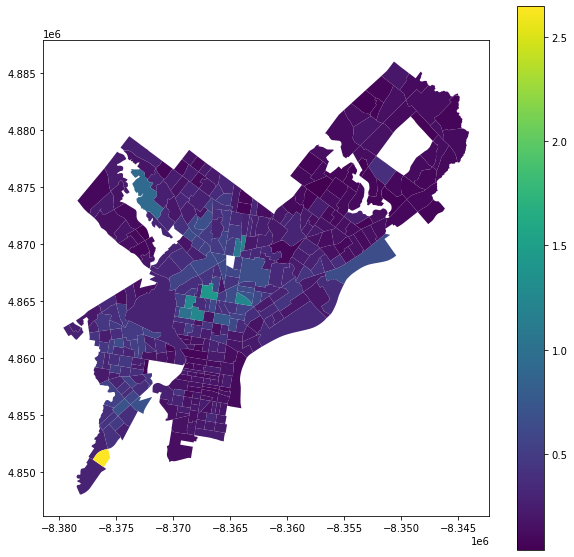

In [104]:
fig, ax = plt.subplots(figsize=(10,10))
Census_tracts[['geometry','percent_error']].plot(ax=ax,column='percent_error',legend=True)

# 8 Disscusion and Limitations

In this study, we examined the relationship between house sale prices and the relevant features using data from the 2020 Philadelphia house sales prices. After cleaning the data, we conducted feature engineering to select the most representative factors influencing the sale price of houses in Philadelphia to train the model. We then conducted linear regression and random forest regression analyses and compared the performance of the two models in predicting the dependent variable (home sale price).

We found a significant relationship between the comfort, amenity, safety and convenience characteristics of the houses and the selling price of them. These results are consistent with the literature review discussed in the introduction and with our hypotheses. Therefore, these results are not surprising.

Overall, the model that includes all the predictors appears to be a relatively good model under the optimal hyperparameter condition. The model has an R^2 value of 0.7, which means that approximately 70% of the house price selling price is explained by the predictors in the model. This means that there are still other predictors not included in our model that contribute to the variance in house price values. We should be able to improve the fit by adding more features, especially features that capture the selling price of homes within the Philadelphia downtown area (where the model seems to be struggling). The addition of features associated with rivers, airports, and large-scale forest parks can also be helpful.

The overall average absolute percentage error reaches 50% when using the random forest model. The median percent error by census tract is below 30% for the majority of Philadelphia, with some areas (near Philadelphia International Airport) reaching a maximum of 250%. This suggests that the model generated in this study is a good predictor of home sale prices in Philadelphia, except for a few specific areas.

Our model has a number of limitations. One limitation is that we ignore the spatial component used to capture the trend of housing prices depending on the prices of surrounding houses. Another drawback is that we have not checked whether the linear model meets the important assumptions required for regression, only multicollinearity between variables has been checked. In addition, the results may be affected by modifiable area unit problems (Openshaw 1984) and therefore the conclusions drawn from the regression models may differ at different scales and when changing  𝑘  values for distance-based features.

Despite these limitations, this study analyses a number of factors that have an impact on house sales prices in Philadelphia and examines the performance of a random forest model in conducting house price forecasting.

# References

Lancaster, K. (1966). ‘A New Approach to Consumer Theory’. Journal of Political Economy, 74, pp. 132–132. doi: 10.1086/259131.
Osland, L. (2010). ‘An Application of Spatial Econometrics in Relation to Hedonic House Price Modeling’. Journal of Real Estate Research. Routledge, 32 (3), pp. 289–320. doi: 10.1080/10835547.2010.12091282.
The Secret of Airbnb’s Pricing Algorithm. (2015). IEEE Spectrum. Available at: https://spectrum.ieee.org/the-secret-of-airbnbs-pricing-algorithm 
van der Weele, J. J., Flynn, M. P. and van der Wolk, R. J. (2017). ‘Broken Window Effect’. in Marciano, A. and Ramello, G. B. (eds) Encyclopedia of Law and Economics. New York, NY: Springer New York, pp. 1–4. doi: 10.1007/978-1-4614-7883-6_624-1.

